In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# set up database
conn = sqlite3.connect("student_grades.db")
cursor = conn.cursor()

# create tables
cursor.execute('''
CREATE TABLE IF NOT EXISTS students (
               student_id INTEGER PRIMARY KEY AUTOINCREMENT,
               first_name TEXT,
               last_name TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS grades (
               grade_id INTEGER PRIMARY KEY AUTOINCREMENT,
               student_id INTEGER,
               subject TEXT,
               grade INTEGER,
               FOREIGN KEY (student_id) REFERENCES students(student_id)
)
''')
conn.commit()
conn.close()

In [7]:
# insert data
conn = sqlite3.connect("student_grades.db")
cursor = conn.cursor()

students = [
    ("Alice", "Johnson"), 
    ("Bob", "Smith"), 
    ("Carol", "White"), 
    ("David", "Brown"), 
    ("Eve", "Davis")
    ]

grades = [
    (1, 'Math', 95), (1, 'English', 88), (1, 'History', 90),
    (2, 'Math', 82), (2, 'English', 76), (2, 'History', 85),
    (3, 'Math', 99), (3, 'English', 96), (3, 'History', 97),
    (4, 'Math', 70), (4, 'English', 72), (4, 'History', 62),
    (5, 'Math', 91), (5, 'English', 86), (5, 'History', 88)
]

cursor.executemany("INSERT INTO students (first_name, last_name) VALUES (?, ?)", students)
cursor.executemany("INSERT INTO grades (student_id, subject, grade) VALUES (?, ?, ?)", grades)

conn.commit()
conn.close()

In [8]:
# excecute queries
conn = sqlite3.connect("student_grades.db")
cursor = conn.cursor()

cursor.execute('''
               SELECT students.first_name, students.last_name, grades.subject, grades.grade
               FROM students
               JOIN grades ON students.student_id = grades.student_id
''')

cursor.execute('''
               SELECT students.first_name, students.last_name, AVG(grades.grade)
               FROM students
               JOIN grades ON students.student_id = grades.student_id
               GROUP BY students.student_id
''')

cursor.execute('''
               SELECT students.first_name, students.last_name
               FROM students
               JOIN grades ON students.student_id = grades.student_id
               GROUP BY students.student_id
               ORDER BY AVG(grades.grade) DESC
               LIMIT 1
''')

cursor.execute('''
               SELECT AVG(grade)
               FROM grades
               WHERE subject = "Math"
               GROUP BY subject
''')

cursor.execute('''
               SELECT DISTINCT students.first_name, students.last_name
               FROM students
               JOIN grades ON students.student_id = grades.student_id 
               WHERE grades.grade > 90

''')
conn.close()

In [9]:
# load data into pandas
conn = sqlite3.connect("student_grades.db")
cursor = conn.cursor()

df_students = pd.read_sql_query("SELECT * FROM students", conn)
df_grades = pd.read_sql_query("SELECT * FROM grades", conn)

conn.close()

print(df_students)
print(df_grades)

   student_id first_name last_name
0           1      Alice   Johnson
1           2        Bob     Smith
2           3      Carol     White
3           4      David     Brown
4           5        Eve     Davis
    grade_id  student_id  subject  grade
0          1           1     Math     95
1          2           1  English     88
2          3           1  History     90
3          4           2     Math     82
4          5           2  English     76
5          6           2  History     85
6          7           3     Math     99
7          8           3  English     96
8          9           3  History     97
9         10           4     Math     70
10        11           4  English     72
11        12           4  History     62
12        13           5     Math     91
13        14           5  English     86
14        15           5  History     88


In [10]:
# join to make a single dataframe
conn = sqlite3.connect("student_grades.db")
cursor = conn.cursor()
df_combined = pd.read_sql_query('''
                                SELECT students.first_name, students.last_name, grades.subject, grades.grade
                                FROM students
                                JOIN grades ON students.student_id = grades.student_id
                                ''', conn)
conn.close()

print(df_combined)

   first_name last_name  subject  grade
0       Alice   Johnson     Math     95
1       Alice   Johnson  English     88
2       Alice   Johnson  History     90
3         Bob     Smith     Math     82
4         Bob     Smith  English     76
5         Bob     Smith  History     85
6       Carol     White     Math     99
7       Carol     White  English     96
8       Carol     White  History     97
9       David     Brown     Math     70
10      David     Brown  English     72
11      David     Brown  History     62
12        Eve     Davis     Math     91
13        Eve     Davis  English     86
14        Eve     Davis  History     88


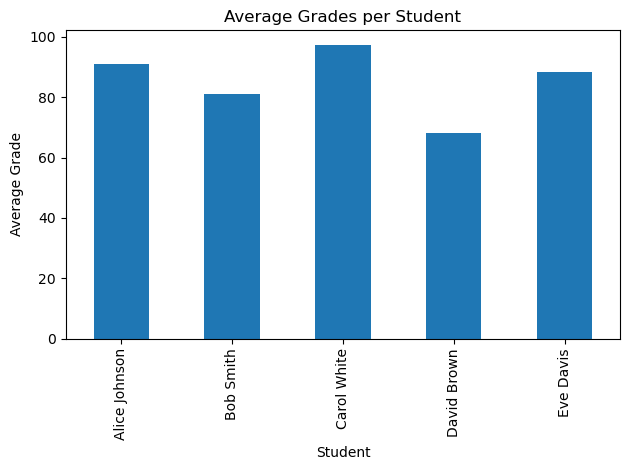

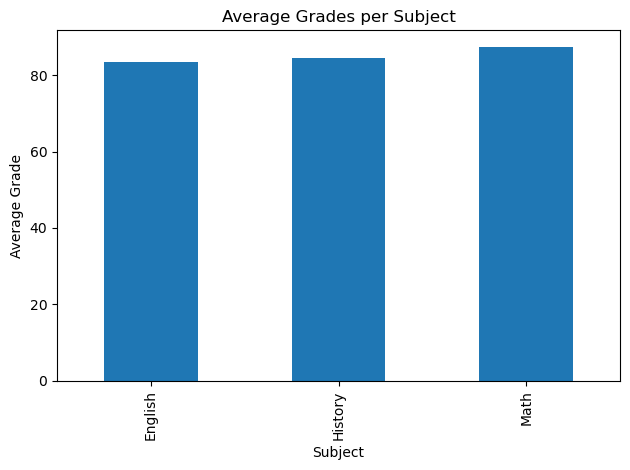

In [11]:
## graphs ##

# average grade per student
df_combined['full_name'] = df_combined['first_name'] + ' ' + df_combined['last_name']
avg_grades_per_student = df_combined.groupby('full_name')['grade'].mean()

# plot
avg_grades_per_student.plot(kind="bar", title="Average Grades per Student")
plt.ylabel('Average Grade')
plt.xlabel('Student')
plt.tight_layout()
plt.show()


# average grade per student
avg_grades_per_subject = df_combined.groupby('subject')['grade'].mean()

# graph
avg_grades_per_subject.plot(kind='bar', title='Average Grades per Subject')
plt.ylabel('Average Grade')
plt.xlabel('Subject')
plt.tight_layout()
plt.show()

In [14]:
# bonus - query
conn = sqlite3.connect("student_grades.db")
cursor = conn.cursor()

# query students with the highest grade
df_highest_grade_per_subject = pd.read_sql_query('''
                                                SELECT students.first_name, students.last_name, grades.subject, MAX(grades.grade) as max_grade
                                                FROM students
                                                JOIN grades ON students.student_id = grades.student_id
                                                GROUP BY grades.subject 
                                                ORDER BY max_grade DESC
                                                ''', conn)
conn.close()

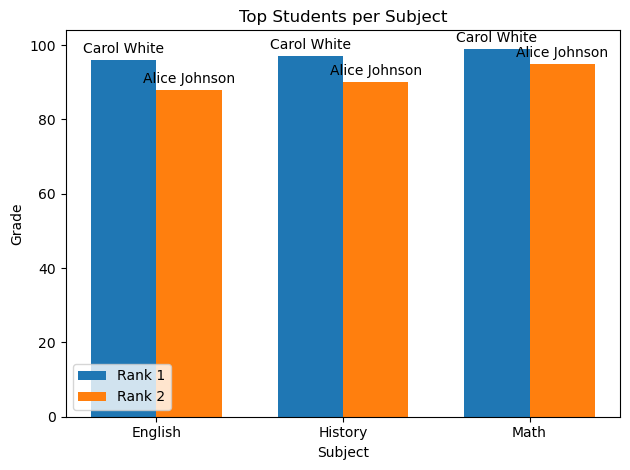

In [15]:
# bonus - grouped bar chart
conn = sqlite3.connect("student_grades.db")
cursor = conn.cursor()

df_top_students_per_subject = pd.read_sql_query('''
WITH RankedGrades AS (
    SELECT students.first_name, students.last_name, grades.subject, grades.grade,
           ROW_NUMBER() OVER (PARTITION BY grades.subject ORDER BY grades.grade DESC) AS rank
    FROM students
    JOIN grades ON students.student_id = grades.student_id
)
SELECT * FROM RankedGrades WHERE rank <= 2
''', conn)

# grouped bar chart

# first/last name
df_top_students_per_subject['full_name'] = df_top_students_per_subject['first_name'] + ' ' + df_top_students_per_subject['last_name']

# unique subjects and top 2
subjects = df_top_students_per_subject['subject'].unique()
ranks = df_top_students_per_subject['rank'].unique()

# spacing
bar_width = 0.35
subject_positions = list(range(len(subjects)))

# create fig
fig, ax = plt.subplots()

# plot students individually
for i, rank in enumerate(ranks):
    rank_data = df_top_students_per_subject[df_top_students_per_subject['rank'] == rank]
    bar_positions = [pos + (i * bar_width) for pos in subject_positions]
    ax.bar(bar_positions, rank_data['grade'], bar_width, label=f'Rank {rank}')
    for j, pos in enumerate(bar_positions):
        ax.text(pos, rank_data['grade'].iloc[j] + 1, rank_data['full_name'].iloc[j], ha='center', va='bottom')

# edit plot
ax.set_xlabel('Subject')
ax.set_ylabel('Grade')
ax.set_title('Top Students per Subject')
ax.set_xticks([pos + bar_width / 2 for pos in subject_positions])
ax.set_xticklabels(subjects)

# legend
ax.legend()


plt.tight_layout()
plt.show()



In [5]:
#### DROP TABLES WHEN NEEDED ####
conn = sqlite3.connect("student_grades.db")
cursor = conn.cursor()

# Drop tables if they exist
cursor.execute('DROP TABLE IF EXISTS students')
cursor.execute('DROP TABLE IF EXISTS grades')

# Commit the changes
conn.commit()
conn.close()